In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [4]:
def generate_synthetic_data(input_dim=10, output_dim=1, num_samples=1000, noise_std=0.1):
    # Teacher network
    teacher_weights = np.random.randn(input_dim, output_dim)
    X = np.random.randn(num_samples, input_dim)
    y_clean = X @ teacher_weights
    y = y_clean + np.random.randn(*y_clean.shape) * noise_std
    return X.astype(np.float32), y.astype(np.float32)

# Generate dataset
X, y = generate_synthetic_data(input_dim=50, output_dim=100, num_samples=10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
class DenseAttentionNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, num_heads=4, dropout=0.1):
        super(DenseAttentionNet, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dims[0])
        
        # Dense blocks with attention
        self.blocks = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            block = nn.Sequential(
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.ReLU(),
                nn.LayerNorm(hidden_dims[i+1]),
                SelfAttention(hidden_dims[i+1], num_heads, dropout),
                nn.Dropout(dropout)
            )
            self.blocks.append(block)
            
        # Skip connections
        self.skip_connections = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            if hidden_dims[i] != hidden_dims[i+1]:
                self.skip_connections.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            else:
                self.skip_connections.append(nn.Identity())
                
        self.output_proj = nn.Linear(hidden_dims[-1], output_dim)
        
    def forward(self, x):
        x = self.input_proj(x)
        for block, skip in zip(self.blocks, self.skip_connections):
            residual = skip(x)
            x = block(x) + residual
        return self.output_proj(x)

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super(SelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        # Reshape for attention: (seq_len, batch_size, embed_dim)
        x = x.unsqueeze(0)
        attn_output, _ = self.attention(x, x, x)
        attn_output = attn_output.squeeze(0)
        return self.norm(attn_output + x.squeeze(0))

# Example model with attention and dense connections
model = DenseAttentionNet(input_dim=50, hidden_dims=[100, 100], output_dim=100)

In [6]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(FullyConnectedNet, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Example model
model = FullyConnectedNet(input_dim=50, hidden_dims=[100, 100], output_dim=100)

In [7]:
def compute_symmetry_breaking_operator(model, loader, device, group_transforms):
    symmetry_breaking_scores = []
    model.eval()
    for x, _ in loader:
        x = x.to(device)
        with torch.no_grad():
            h = model(x)
        symmetry_score = 0
        for g in group_transforms:
            g_h = g(h)  # Apply symmetry transformation
            symmetry_score += torch.norm(h - g_h, p=2)  # L2 norm of difference
        symmetry_breaking_scores.append(symmetry_score.item())
    return np.mean(symmetry_breaking_scores)

In [8]:
def compute_alignment(A, B):
    A_flat = A.flatten()
    B_flat = B.flatten()
    corr, _ = pearsonr(A_flat, B_flat)
    return corr

# def compute_covariances(model, loader, device):
#     H, G, W = [], [], []
#     model.eval()
#     for x, y in loader:
#         x, y = x.to(device), y.to(device)
#         outputs = model(x)
#         loss = nn.MSELoss()(outputs, y)
#         loss.backward()

#         # Collect activations and gradients per layer
#         for layer in model.net:
#             if isinstance(layer, nn.Linear):
#                 h = layer.weight.detach().cpu().numpy()
#                 g = layer.weight.grad.detach().cpu().numpy()
#                 w = layer.weight.detach().cpu().numpy()
#                 H.append(h.flatten())  # Flatten to 1D array
#                 G.append(g.flatten())  # Flatten to 1D array
#                 W.append(w.flatten())  # Flatten to 1D array

#         # Zero gradients
#         model.zero_grad()

#     # Convert lists to arrays and compute means
#     H = np.concatenate(H)
#     G = np.concatenate(G)
#     W = np.concatenate(W)
#     return H, G, W

def compute_covariances(model, loader, device):
    H, G, W = [], [], []
    model.eval()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = nn.MSELoss()(outputs, y)
        loss.backward()

        # Collect activations and gradients per layer
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Linear):
                h = layer.weight.detach().cpu().numpy()
                g = layer.weight.grad.detach().cpu().numpy()
                w = layer.weight.detach().cpu().numpy()
                H.append(h.flatten())  # Flatten to 1D array
                G.append(g.flatten())  # Flatten to 1D array
                W.append(w.flatten())  # Flatten to 1D array

        # Zero gradients
        model.zero_grad()

    # Convert lists to arrays and compute means
    H = np.concatenate(H)
    G = np.concatenate(G)
    W = np.concatenate(W)
    return H, G, W

In [9]:
def train_model(model, train_loader, test_loader, epochs=100, lr=0.001, weight_decay=0.01, device='cpu', group_transforms=None):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    alignment_history = []
    symmetry_breaking_history = []
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

        # Compute alignment metrics
        H, G, W = compute_covariances(model, test_loader, device)
        rho_HG = compute_alignment(H, G)
        rho_HW = compute_alignment(H, W)
        rho_GW = compute_alignment(G, W)
        alignment_history.append((rho_HG, rho_HW, rho_GW))

        # Compute symmetry-breaking score
        sb_score = compute_symmetry_breaking_operator(model, test_loader, device, group_transforms)
        symmetry_breaking_history.append(sb_score)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, "
              f"ρ(H,G): {rho_HG:.4f}, ρ(H,W): {rho_HW:.4f}, ρ(G,W): {rho_GW:.4f}, "
              f"Symmetry Breaking Score: {sb_score:.4f}")

    return alignment_history, symmetry_breaking_history



In [10]:
def rotate_90(h):
    # Reshape to 2D matrix and rotate
    batch_size, output_dim = h.shape
    # Reshape to square matrix if possible
    side_length = int(np.sqrt(output_dim))
    if side_length * side_length == output_dim:
        h_reshaped = h.reshape(batch_size, side_length, side_length)  # Changed view to reshape
        return torch.rot90(h_reshaped, k=1, dims=(1, 2)).reshape(batch_size, -1)  # Changed view to reshape
    else:
        # If not a perfect square, return original
        return h

In [11]:
device = torch.device("mps")
# Define group transforms (in this case, just the rotation transform)
group_transforms = [rotate_90]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FullyConnectedNet(input_dim=50, hidden_dims=[100, 100], output_dim=100).to(device)

model = DenseAttentionNet(input_dim=50, hidden_dims=[100, 100], output_dim=100).to(device)

# Train model and collect alignment metrics and symmetry-breaking scores
alignment_history, symmetry_breaking_history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=100,
    lr=0.001,
    weight_decay=0.01,
    device=device,
    group_transforms=group_transforms
)

Epoch 1/100, Loss: 21.7741, ρ(H,G): -0.4235, ρ(H,W): 1.0000, ρ(G,W): -0.4235, Symmetry Breaking Score: 344.9220
Epoch 2/100, Loss: 5.8527, ρ(H,G): -0.3804, ρ(H,W): 1.0000, ρ(G,W): -0.3804, Symmetry Breaking Score: 600.7491
Epoch 3/100, Loss: 1.6063, ρ(H,G): -0.2090, ρ(H,W): 1.0000, ρ(G,W): -0.2090, Symmetry Breaking Score: 707.4387
Epoch 4/100, Loss: 0.9468, ρ(H,G): -0.1614, ρ(H,W): 1.0000, ρ(G,W): -0.1614, Symmetry Breaking Score: 739.8885
Epoch 5/100, Loss: 0.8995, ρ(H,G): -0.1588, ρ(H,W): 1.0000, ρ(G,W): -0.1588, Symmetry Breaking Score: 745.7303
Epoch 6/100, Loss: 0.8395, ρ(H,G): -0.1726, ρ(H,W): 1.0000, ρ(G,W): -0.1726, Symmetry Breaking Score: 745.9740
Epoch 7/100, Loss: 0.8540, ρ(H,G): -0.1854, ρ(H,W): 1.0000, ρ(G,W): -0.1854, Symmetry Breaking Score: 745.3483
Epoch 8/100, Loss: 0.7576, ρ(H,G): -0.1861, ρ(H,W): 1.0000, ρ(G,W): -0.1861, Symmetry Breaking Score: 747.3384
Epoch 9/100, Loss: 0.8108, ρ(H,G): -0.1942, ρ(H,W): 1.0000, ρ(G,W): -0.1942, Symmetry Breaking Score: 747.1563


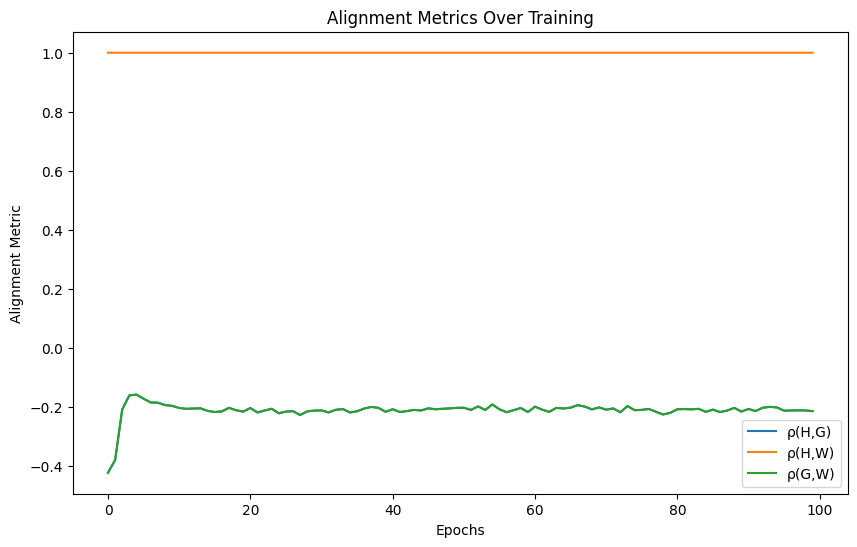

In [12]:
def plot_alignment_metrics(alignment_history):
    rho_HG = [x[0] for x in alignment_history]
    rho_HW = [x[1] for x in alignment_history]
    rho_GW = [x[2] for x in alignment_history]

    plt.figure(figsize=(10, 6))
    plt.plot(rho_HG, label="ρ(H,G)")
    plt.plot(rho_HW, label="ρ(H,W)")
    plt.plot(rho_GW, label="ρ(G,W)")
    plt.xlabel("Epochs")
    plt.ylabel("Alignment Metric")
    plt.title("Alignment Metrics Over Training")
    plt.legend()
    plt.show()

plot_alignment_metrics(alignment_history)

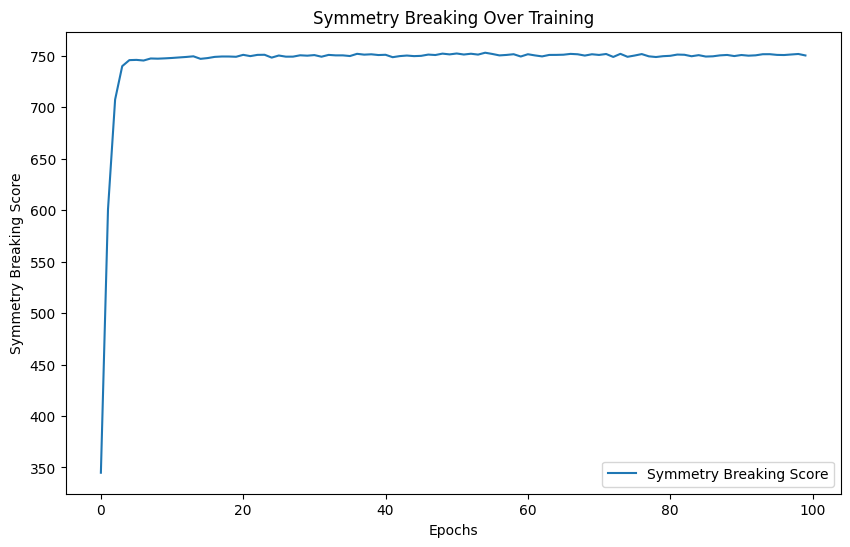

In [13]:
def plot_symmetry_breaking(symmetry_breaking_history):
    plt.figure(figsize=(10, 6))
    plt.plot(symmetry_breaking_history, label="Symmetry Breaking Score")
    plt.xlabel("Epochs")
    plt.ylabel("Symmetry Breaking Score")
    plt.title("Symmetry Breaking Over Training")
    plt.legend()
    plt.show()

plot_symmetry_breaking(symmetry_breaking_history)

## with power law exponents

In [14]:
# ... existing imports ...
from scipy.stats import linregress

def compute_power_law_exponent(matrix):
    eigenvalues = np.linalg.eigvalsh(matrix)
    eigenvalues = eigenvalues[eigenvalues > 0]  # Avoid zero or negative values
    log_eigenvalues = np.log(eigenvalues)
    indices = np.arange(1, len(log_eigenvalues) + 1)
    slope, _, _, _, _ = linregress(np.log(indices), log_eigenvalues)
    return slope

# def compute_layer_power_laws(model):
#     power_laws = []
#     for layer in model.net:
#         if isinstance(layer, nn.Linear):
#             weight_matrix = layer.weight.detach().cpu().numpy()
#             cov_matrix = weight_matrix.T @ weight_matrix
#             power_laws.append(compute_power_law_exponent(cov_matrix))
#     return power_laws

def compute_layer_power_laws(model):
    power_laws = []
    # Handle both FullyConnectedNet and DenseAttentionNet
    if hasattr(model, 'net'):  # For FullyConnectedNet
        layers = model.net
    else:  # For DenseAttentionNet
        layers = []
        for name, module in model.named_modules():
            if isinstance(module, nn.Linear):
                layers.append(module)
    
    for layer in layers:
        if isinstance(layer, nn.Linear):
            weight_matrix = layer.weight.detach().cpu().numpy()
            cov_matrix = weight_matrix.T @ weight_matrix
            power_laws.append(compute_power_law_exponent(cov_matrix))
    return power_laws

def train_model(model, train_loader, test_loader, epochs=100, lr=0.001, weight_decay=0.01, device='cpu', group_transforms=None):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    alignment_history = []
    symmetry_breaking_history = []
    power_law_history = []  # New: to store power law exponents
    
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

        # Compute alignment metrics
        H, G, W = compute_covariances(model, test_loader, device)
        rho_HG = compute_alignment(H, G)
        rho_HW = compute_alignment(H, W)
        rho_GW = compute_alignment(G, W)
        alignment_history.append((rho_HG, rho_HW, rho_GW))

        # Compute symmetry-breaking score
        sb_score = compute_symmetry_breaking_operator(model, test_loader, device, group_transforms)
        symmetry_breaking_history.append(sb_score)

        # Compute power law exponents for each layer
        power_laws = compute_layer_power_laws(model)
        power_law_history.append(power_laws)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, "
              f"ρ(H,G): {rho_HG:.4f}, ρ(H,W): {rho_HW:.4f}, ρ(G,W): {rho_GW:.4f}, "
              f"Symmetry Breaking Score: {sb_score:.4f}")
        print(f"Power Law Exponents: {[f'{x:.4f}' for x in power_laws]}")

    return alignment_history, symmetry_breaking_history, power_law_history

def plot_power_laws(power_law_history):
    plt.figure(figsize=(12, 6))
    # Transpose to get per-layer data
    power_law_history = np.array(power_law_history).T
    for i, layer_power_laws in enumerate(power_law_history):
        plt.plot(layer_power_laws, label=f'Layer {i+1}')
    plt.xlabel("Epochs")
    plt.ylabel("Power Law Exponent")
    plt.title("Power Law Exponents Over Training")
    plt.legend()
    plt.show()

Epoch 1/10, Loss: 0.4623, ρ(H,G): -0.2016, ρ(H,W): 1.0000, ρ(G,W): -0.2016, Symmetry Breaking Score: 753.0326
Power Law Exponents: ['0.5658', '3.9000', '3.6571', '6.0074']
Epoch 2/10, Loss: 0.4817, ρ(H,G): -0.2072, ρ(H,W): 1.0000, ρ(G,W): -0.2072, Symmetry Breaking Score: 750.5859
Power Law Exponents: ['0.5653', '4.1170', '3.5109', '6.0105']
Epoch 3/10, Loss: 0.4047, ρ(H,G): -0.2082, ρ(H,W): 1.0000, ρ(G,W): -0.2082, Symmetry Breaking Score: 751.4044
Power Law Exponents: ['0.5657', '4.0425', '3.6480', '6.1679']
Epoch 4/10, Loss: 0.4454, ρ(H,G): -0.2044, ρ(H,W): 1.0000, ρ(G,W): -0.2044, Symmetry Breaking Score: 750.4738
Power Law Exponents: ['0.5643', '4.0193', '3.7649', '6.3497']
Epoch 5/10, Loss: 0.5157, ρ(H,G): -0.2053, ρ(H,W): 1.0000, ρ(G,W): -0.2053, Symmetry Breaking Score: 751.7039
Power Law Exponents: ['0.5643', '4.1786', '4.1003', '6.3681']
Epoch 6/10, Loss: 0.4435, ρ(H,G): -0.2075, ρ(H,W): 1.0000, ρ(G,W): -0.2075, Symmetry Breaking Score: 751.4627
Power Law Exponents: ['0.5653'

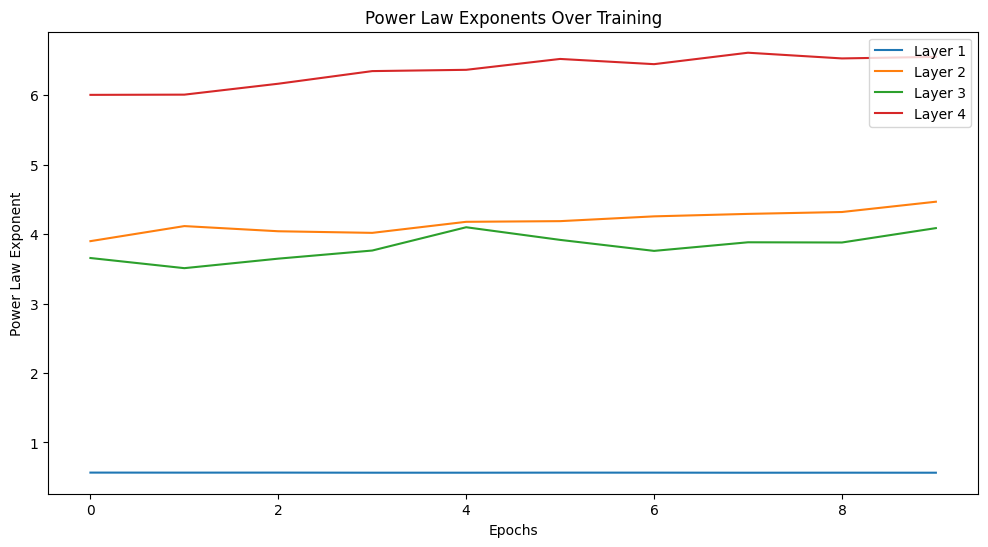

In [ ]:
# Train model and collect metrics
alignment_history, symmetry_breaking_history, power_law_history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=10,
    lr=0.001,
    weight_decay=0.01,
    device=device,
    group_transforms=group_transforms
)

# Plot power laws
plot_power_laws(power_law_history)

In [16]:
def plot_alignment_metrics(alignment_history):
    rho_HG = [x[0] for x in alignment_history]
    rho_HW = [x[1] for x in alignment_history]
    rho_GW = [x[2] for x in alignment_history]

    plt.figure(figsize=(10, 6))
    # Add alpha (transparency) and adjust linewidth
    plt.plot(rho_HG, label="ρ(H,G)", alpha=0.7, linewidth=2)
    plt.plot(rho_HW, label="ρ(H,W)", alpha=0.7, linewidth=2)
    plt.plot(rho_GW, label="ρ(G,W)", alpha=0.7, linewidth=2)
    
    # Print the final values
    print(f"Final values:")
    print(f"ρ(H,G): {rho_HG[-1]:.4f}")
    print(f"ρ(H,W): {rho_HW[-1]:.4f}")
    print(f"ρ(G,W): {rho_GW[-1]:.4f}")
    
    plt.xlabel("Epochs")
    plt.ylabel("Alignment Metric")
    plt.title("Alignment Metrics Over Training")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Final values:
ρ(H,G): -0.2072
ρ(H,W): 1.0000
ρ(G,W): -0.2072


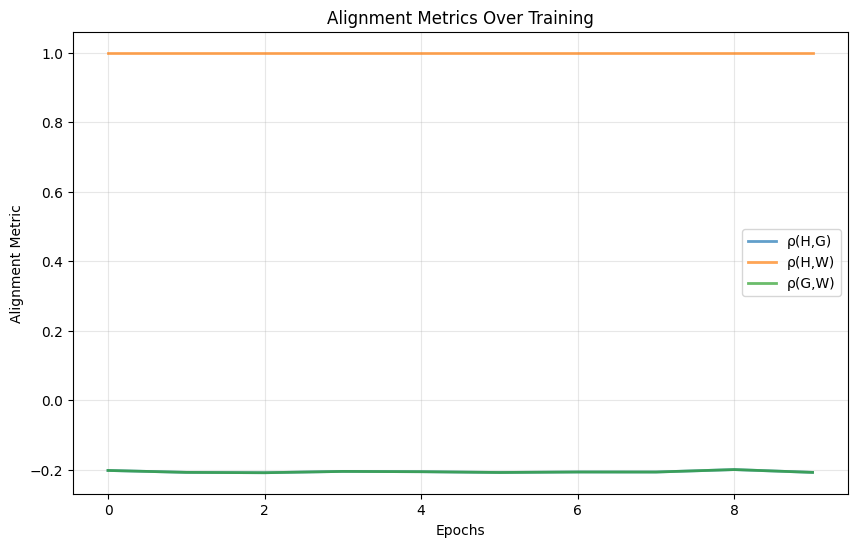

In [17]:
plot_alignment_metrics(alignment_history)

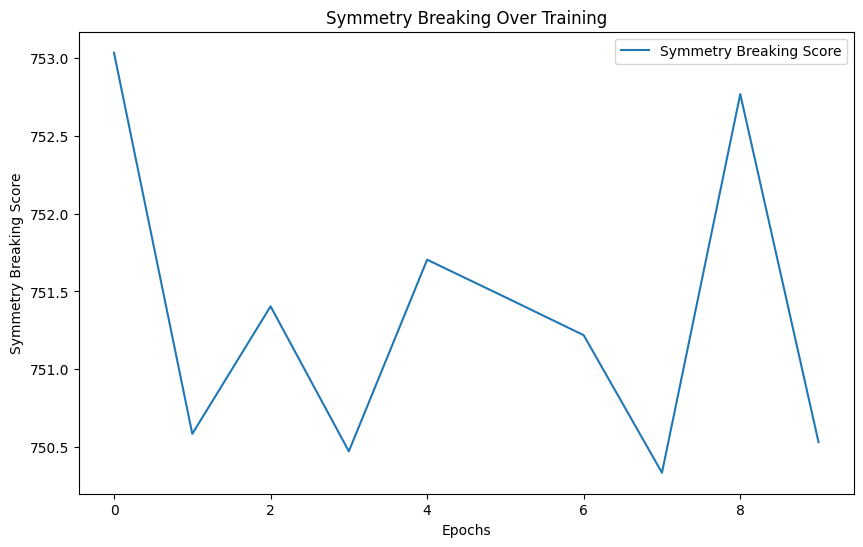

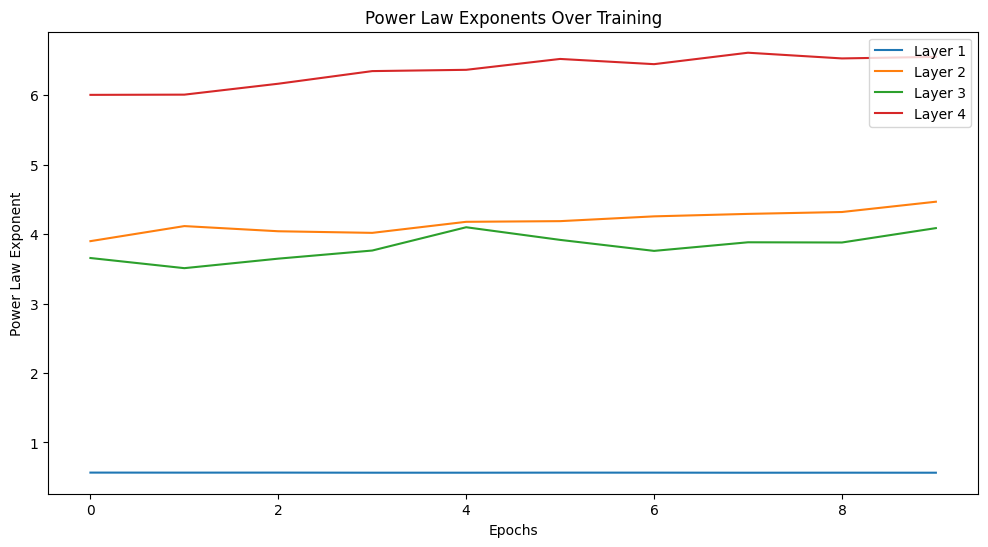

In [18]:
plot_symmetry_breaking(symmetry_breaking_history)
plot_power_laws(power_law_history)

### New Metrics

1. **Gradient Norm Ratio (GNR):**
   This metric measures the ratio of gradient norms between consecutive layers. It provides insight into how gradients propagate through the network and whether there's a bottleneck or amplification in certain layers.

   For a network with L layers, the GNR between layer l and l+1 is defined as:

   \[
   GNR_l = \frac{||\nabla W_l||_2}{||\nabla W_{l+1}||_2}
   \]

   where \(||\nabla W_l||_2\) is the L2 norm of the weight gradients at layer l.

2. **Representation Compactness Score (RCS):**
   This metric quantifies how compact the representations are by measuring the rank of the covariance matrix of activations. Lower rank indicates more compact representations.

   Given the hidden layer activations \(H \in \mathbb{R}^{n \times d}\), where n is the number of samples and d is the hidden dimension, the RCS is computed as:

   \[
   RCS = rank(\Sigma_H)
   \]

   where \(\Sigma_H = \frac{1}{n-1}H^TH\) is the sample covariance matrix of the activations.

3. **Task-Relevant Feature Alignment (TRFA):**
   This metric measures the alignment between task-relevant features and latent representations. It uses the top principal components of the covariance matrix to assess alignment.

   Let \(v_1\) be the top eigenvector of \(\Sigma_H\) (the direction of maximum variance), and \(\mu_H\) be the mean activation vector. The TRFA is computed as:

   \[
   TRFA = |v_1^T \mu_H|
   \]

   This measures how well the mean activation aligns with the direction of maximum variance in the representation space.

These new metrics provide deeper insights into the dynamics of representation learning, gradient flow, and task-relevance in neural networks. They extend the CRH and PAH frameworks by offering concrete, measurable ways to track and understand these phenomena throughout training.

In [19]:
def compute_gradient_norm_ratio(model, loader, device):
    model.eval()
    gradient_norms = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = nn.MSELoss()(outputs, y)
        loss.backward()
        layer_gradients = []
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Linear):
                grad_norm = torch.norm(layer.weight.grad, p=2).item()
                layer_gradients.append(grad_norm)
        gradient_norms.append(layer_gradients)
        model.zero_grad()
    gradient_norms = np.array(gradient_norms)
    mean_gradient_norms = np.mean(gradient_norms, axis=0)
    gnr = mean_gradient_norms[:-1] / mean_gradient_norms[1:]
    return gnr

In [20]:
def compute_representation_compactness(model, loader, device):
    model.eval()
    compactness_scores = []
    for x, _ in loader:
        x = x.to(device)
        with torch.no_grad():
            h = model(x)
            cov_matrix = np.cov(h.cpu().numpy(), rowvar=False)
            rank = np.linalg.matrix_rank(cov_matrix)
            compactness_scores.append(rank)
    return np.mean(compactness_scores)

In [21]:
def compute_task_relevant_feature_alignment(model, loader, device):
    model.eval()
    alignments = []
    for x, _ in loader:
        x = x.to(device)
        with torch.no_grad():
            h = model(x)
            cov_matrix = np.cov(h.cpu().numpy(), rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
            sorted_indices = np.argsort(eigenvalues)[::-1]
            top_eigenvector = eigenvectors[:, sorted_indices[0]]
            alignment = np.abs(np.dot(top_eigenvector, h.mean(axis=0).cpu().numpy()))
            alignments.append(alignment)
    return np.mean(alignments)

In [22]:
def train_model(model, train_loader, test_loader, epochs=100, lr=0.001, weight_decay=0.01, device='cpu', group_transforms=None):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    alignment_history = []
    symmetry_breaking_history = []
    power_law_history = []
    gnr_history = []
    rcs_history = []
    trfa_history = []

    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

        # Compute alignment metrics
        H, G, W = compute_covariances(model, test_loader, device)
        rho_HG = compute_alignment(H, G)
        rho_HW = compute_alignment(H, W)
        rho_GW = compute_alignment(G, W)
        alignment_history.append((rho_HG, rho_HW, rho_GW))

        # Compute symmetry-breaking score
        sb_score = compute_symmetry_breaking_operator(model, test_loader, device, group_transforms)
        symmetry_breaking_history.append(sb_score)

        # Compute power law exponents for each layer
        power_laws = compute_layer_power_laws(model)
        power_law_history.append(power_laws)

        # Compute Gradient Norm Ratio
        gnr = compute_gradient_norm_ratio(model, test_loader, device)
        gnr_history.append(gnr)

        # Compute Representation Compactness Score
        rcs = compute_representation_compactness(model, test_loader, device)
        rcs_history.append(rcs)

        # Compute Task-Relevant Feature Alignment
        trfa = compute_task_relevant_feature_alignment(model, test_loader, device)
        trfa_history.append(trfa)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, "
              f"ρ(H,G): {rho_HG:.4f}, ρ(H,W): {rho_HW:.4f}, ρ(G,W): {rho_GW:.4f}, "
              f"Symmetry Breaking Score: {sb_score:.4f}, "
              f"Power Law Exponents: {[f'{x:.4f}' for x in power_laws]}, "
              f"Gradient Norm Ratios: {[f'{x:.4f}' for x in gnr]}, "
              f"Representation Compactness Score: {rcs:.4f}, "
              f"Task-Relevant Feature Alignment: {trfa:.4f}")

    return alignment_history, symmetry_breaking_history, power_law_history, gnr_history, rcs_history, trfa_history

### gradient flow analysis

In [23]:
def plot_gradient_norm_ratios(gnr_history):
    plt.figure(figsize=(12, 6))
    gnr_history = np.array(gnr_history).T
    for i, layer_gnr in enumerate(gnr_history):
        plt.plot(layer_gnr, label=f'Layer {i+1} to {i+2}')
    plt.xlabel("Epochs")
    plt.ylabel("Gradient Norm Ratio")
    plt.title("Gradient Norm Ratios Over Training")
    plt.legend()
    plt.show()

### Compactness Evolution:


In [24]:
def plot_representation_compactness(rcs_history):
    plt.figure(figsize=(10, 6))
    plt.plot(rcs_history, label="Representation Compactness Score")
    plt.xlabel("Epochs")
    plt.ylabel("Compactness Score")
    plt.title("Representation Compactness Over Training")
    plt.legend()
    plt.show()

### Task-Relevant Feature Alignment:


In [25]:
def plot_task_relevant_feature_alignment(trfa_history):
    plt.figure(figsize=(10, 6))
    plt.plot(trfa_history, label="Task-Relevant Feature Alignment")
    plt.xlabel("Epochs")
    plt.ylabel("Alignment Score")
    plt.title("Task-Relevant Feature Alignment Over Training")
    plt.legend()
    plt.show()

Epoch 1/100, Loss: 5.5575, ρ(H,G): -0.4845, ρ(H,W): 1.0000, ρ(G,W): -0.4845, Symmetry Breaking Score: 555.2340, Power Law Exponents: ['0.7045', '3.3857', '3.3800', '4.4122'], Gradient Norm Ratios: ['0.5599', '113.9805', '0.0116'], Representation Compactness Score: 61.5000, Task-Relevant Feature Alignment: 1.2522
Epoch 2/100, Loss: 5.8264, ρ(H,G): -0.4147, ρ(H,W): 1.0000, ρ(G,W): -0.4147, Symmetry Breaking Score: 548.3619, Power Law Exponents: ['0.8524', '3.5470', '3.7692', '5.2689'], Gradient Norm Ratios: ['0.4368', '131.5835', '0.0129'], Representation Compactness Score: 61.5000, Task-Relevant Feature Alignment: 1.2852
Epoch 3/100, Loss: 5.9911, ρ(H,G): -0.3943, ρ(H,W): 1.0000, ρ(G,W): -0.3943, Symmetry Breaking Score: 548.4779, Power Law Exponents: ['0.9605', '3.6947', '3.8244', '5.6778'], Gradient Norm Ratios: ['0.4048', '133.1834', '0.0137'], Representation Compactness Score: 61.5000, Task-Relevant Feature Alignment: 1.2980
Epoch 4/100, Loss: 5.6020, ρ(H,G): -0.3711, ρ(H,W): 1.0000

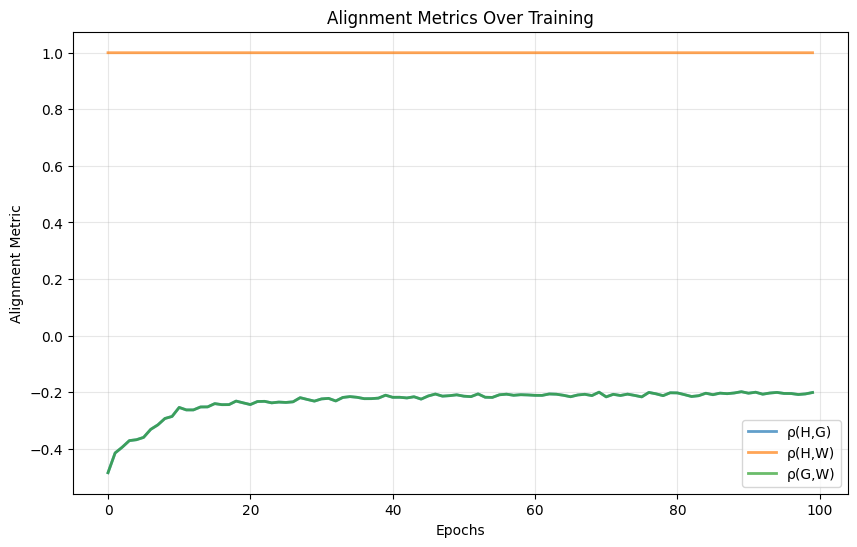

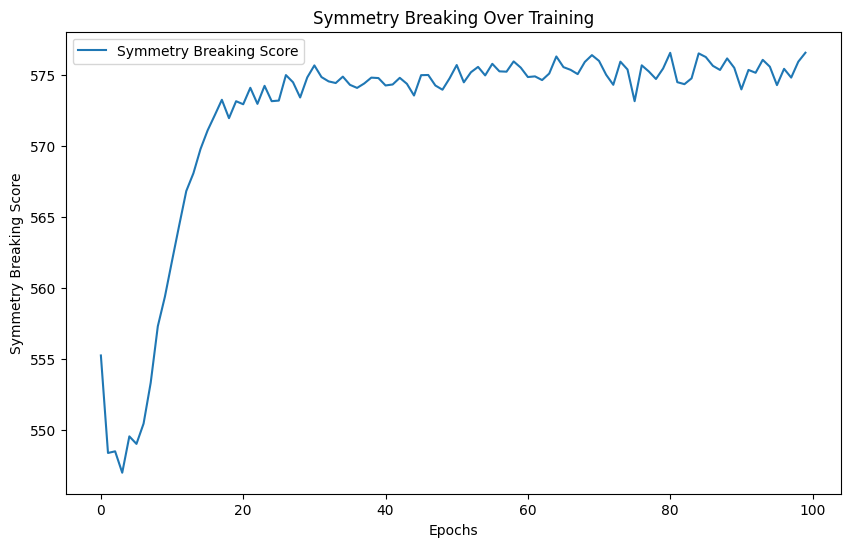

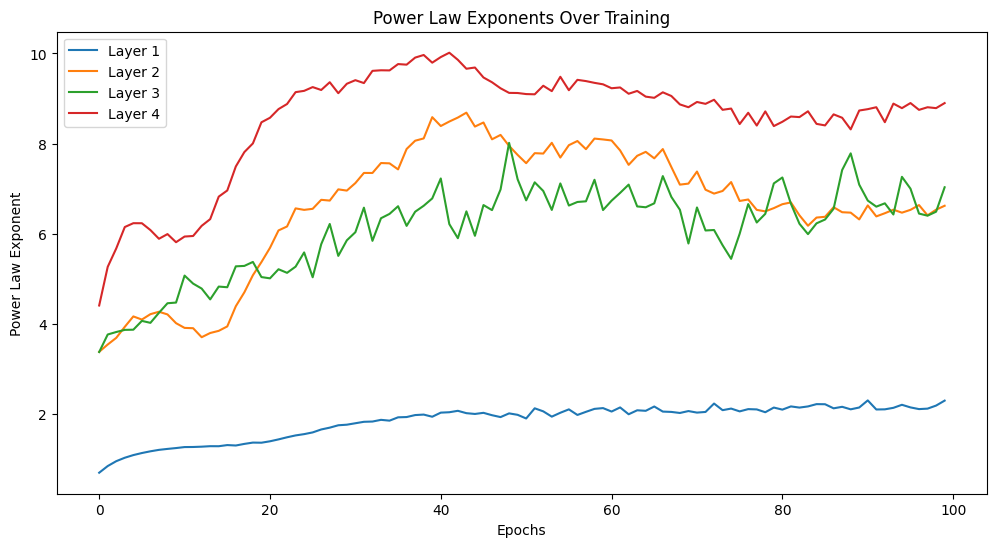

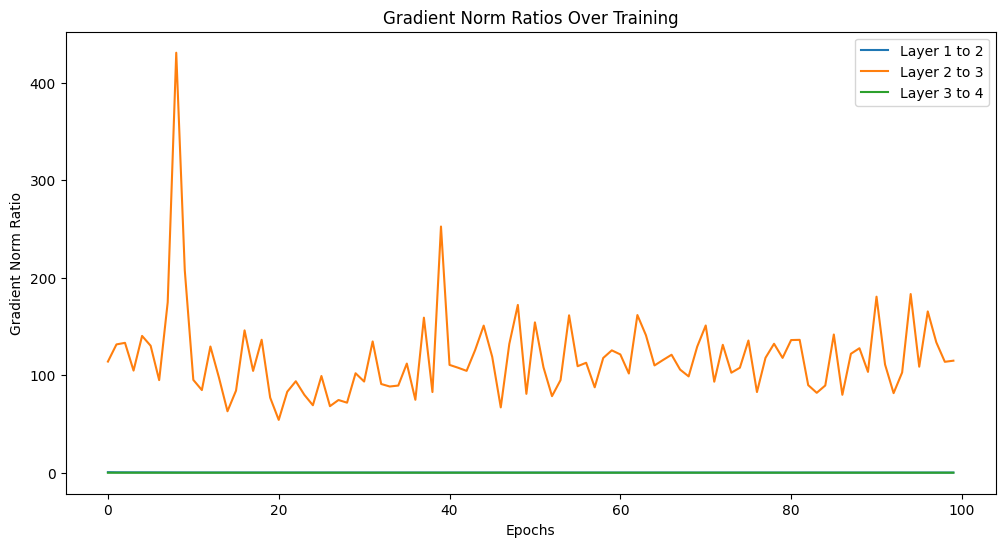

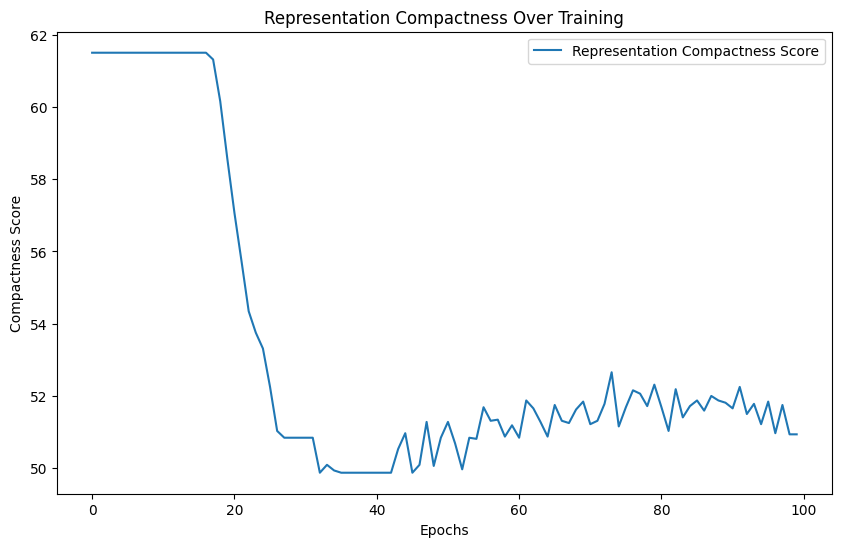

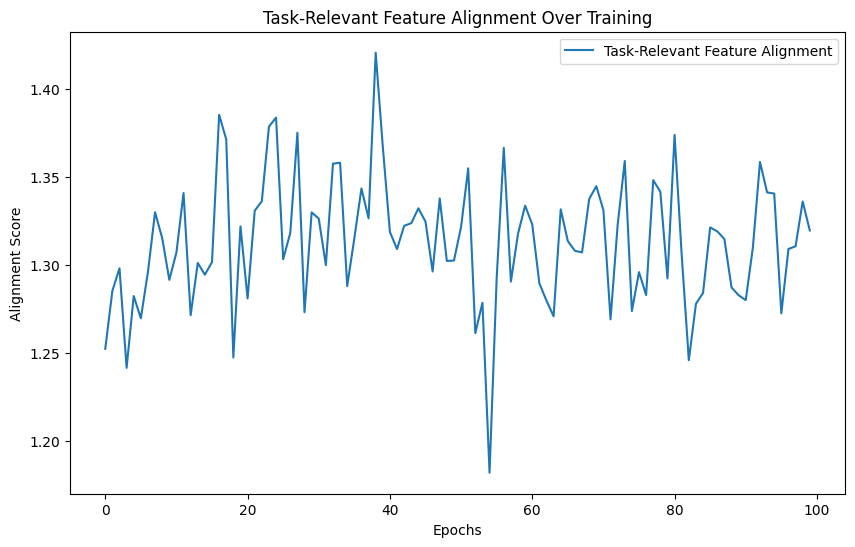

In [26]:
# Train model and collect metrics
alignment_history, symmetry_breaking_history, power_law_history, gnr_history, rcs_history, trfa_history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=100,
    lr=0.001,
    weight_decay=0.09,
    device=device,
    group_transforms=group_transforms
)

# Plot all metrics
plot_alignment_metrics(alignment_history)
plot_symmetry_breaking(symmetry_breaking_history)
plot_power_laws(power_law_history)
plot_gradient_norm_ratios(gnr_history)
plot_representation_compactness(rcs_history)
plot_task_relevant_feature_alignment(trfa_history)

## more metrics

In [27]:
def compute_gradient_norm_ratio(model, loader, device):
    model.eval()
    gradient_norms = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = nn.MSELoss()(outputs, y)
        loss.backward()
        layer_gradients = []
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Linear):
                grad_norm = torch.norm(layer.weight.grad, p=2).item()
                layer_gradients.append(grad_norm)
        gradient_norms.append(layer_gradients)
        model.zero_grad()
    gradient_norms = np.array(gradient_norms)
    mean_gradient_norms = np.mean(gradient_norms, axis=0)
    gnr = mean_gradient_norms[:-1] / mean_gradient_norms[1:]
    return gnr

def compute_representation_compactness(model, loader, device):
    model.eval()
    compactness_scores = []
    for x, _ in loader:
        x = x.to(device)
        with torch.no_grad():
            h = model(x)
            cov_matrix = np.cov(h.cpu().numpy(), rowvar=False)
            rank = np.linalg.matrix_rank(cov_matrix)
            compactness_scores.append(rank)
    return np.mean(compactness_scores)

def compute_task_relevant_feature_alignment(model, loader, device):
    model.eval()
    alignments = []
    for x, _ in loader:
        x = x.to(device)
        with torch.no_grad():
            h = model(x)
            cov_matrix = np.cov(h.cpu().numpy(), rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
            sorted_indices = np.argsort(eigenvalues)[::-1]
            top_eigenvector = eigenvectors[:, sorted_indices[0]]
            alignment = np.abs(np.dot(top_eigenvector, h.mean(axis=0).cpu().numpy()))
            alignments.append(alignment)
    return np.mean(alignments)

# def compute_plasticity_expressivity_coupling(model, loader, device):
#     model.eval()
#     expressivity = []
#     plasticity = []
#     for x, _ in loader:
#         x = x.to(device)
#         with torch.no_grad():
#             h = model(x)
#             expressivity.append(torch.var(h, dim=0).cpu().numpy())
#         outputs = model(x)
#         loss = nn.MSELoss()(outputs, torch.zeros_like(outputs))
#         loss.backward()
#         for name, layer in model.named_modules():
#             if isinstance(layer, nn.Linear):
#                 plasticity.append(torch.var(layer.weight.grad, dim=0).cpu().numpy())
#         model.zero_grad()
#     expressivity = np.concatenate(expressivity)
#     plasticity = np.concatenate(plasticity)
#     coupling = pearsonr(expressivity.flatten(), plasticity.flatten())[0]
#     return coupling

def compute_plasticity_expressivity_coupling(model, loader, device):
    model.eval()
    expressivity = []
    plasticity = []
    for x, _ in loader:
        x = x.to(device)
        with torch.no_grad():
            h = model(x)
            expressivity.append(h.cpu().numpy())
        outputs = model(x)
        loss = nn.MSELoss()(outputs, torch.zeros_like(outputs))
        loss.backward()
        layer_gradients = []
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Linear):
                layer_gradients.append(layer.weight.grad.cpu().numpy())
        plasticity.append(np.concatenate([g.flatten() for g in layer_gradients]))
        model.zero_grad()
    
    # Flatten and concatenate all values
    expressivity = np.concatenate([e.flatten() for e in expressivity])
    plasticity = np.concatenate(plasticity)
    
    # Ensure both arrays have the same length
    min_length = min(len(expressivity), len(plasticity))
    expressivity = expressivity[:min_length]
    plasticity = plasticity[:min_length]
    
    coupling = pearsonr(expressivity, plasticity)[0]
    return coupling

# def compute_feature_importance_alignment(model, loader, device):
#     model.eval()
#     importance_alignments = []
#     for x, _ in loader:
#         x = x.to(device)
#         outputs = model(x)
#         loss = nn.MSELoss()(outputs, torch.zeros_like(outputs))
#         loss.backward()
#         for name, layer in model.named_modules():
#             if isinstance(layer, nn.Linear):
#                 grad_norm = torch.norm(layer.weight.grad, p=2, dim=1).cpu().numpy()
#                 activation_norm = torch.norm(layer.weight, p=2, dim=1).cpu().numpy()
#                 alignment = pearsonr(grad_norm, activation_norm)[0]
#                 importance_alignments.append(alignment)
#         model.zero_grad()
#     return np.mean(importance_alignments)

def compute_feature_importance_alignment(model, loader, device):
    model.eval()
    importance_alignments = []
    for x, _ in loader:
        x = x.to(device)
        outputs = model(x)
        loss = nn.MSELoss()(outputs, torch.zeros_like(outputs))
        loss.backward()
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Linear):
                grad_norm = torch.norm(layer.weight.grad, p=2, dim=1).detach().cpu().numpy()
                activation_norm = torch.norm(layer.weight, p=2, dim=1).detach().cpu().numpy()
                alignment = pearsonr(grad_norm, activation_norm)[0]
                importance_alignments.append(alignment)
        model.zero_grad()
    return np.mean(importance_alignments)

In [28]:
def train_model(model, train_loader, test_loader, epochs=100, lr=0.001, weight_decay=0.01, device='cpu', group_transforms=None):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    alignment_history = []
    symmetry_breaking_history = []
    power_law_history = []
    gnr_history = []
    rcs_history = []
    trfa_history = []
    pec_history = []
    fia_history = []

    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

        # Compute alignment metrics
        H, G, W = compute_covariances(model, test_loader, device)
        rho_HG = compute_alignment(H, G)
        rho_HW = compute_alignment(H, W)
        rho_GW = compute_alignment(G, W)
        alignment_history.append((rho_HG, rho_HW, rho_GW))

        # Compute symmetry-breaking score
        sb_score = compute_symmetry_breaking_operator(model, test_loader, device, group_transforms)
        symmetry_breaking_history.append(sb_score)

        # Compute power law exponents for each layer
        power_laws = compute_layer_power_laws(model)
        power_law_history.append(power_laws)

        # Compute Gradient Norm Ratio
        gnr = compute_gradient_norm_ratio(model, test_loader, device)
        gnr_history.append(gnr)

        # Compute Representation Compactness Score
        rcs = compute_representation_compactness(model, test_loader, device)
        rcs_history.append(rcs)

        # Compute Task-Relevant Feature Alignment
        trfa = compute_task_relevant_feature_alignment(model, test_loader, device)
        trfa_history.append(trfa)

        # Compute Plasticity-Expressivity Coupling
        pec = compute_plasticity_expressivity_coupling(model, test_loader, device)
        pec_history.append(pec)

        # Compute Feature Importance Alignment
        fia = compute_feature_importance_alignment(model, test_loader, device)
        fia_history.append(fia)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, "
              f"ρ(H,G): {rho_HG:.4f}, ρ(H,W): {rho_HW:.4f}, ρ(G,W): {rho_GW:.4f}, "
              f"Symmetry Breaking Score: {sb_score:.4f}, "
              f"Power Law Exponents: {[f'{x:.4f}' for x in power_laws]}, "
              f"Gradient Norm Ratios: {[f'{x:.4f}' for x in gnr]}, "
              f"Representation Compactness Score: {rcs:.4f}, "
              f"Task-Relevant Feature Alignment: {trfa:.4f}, "
              f"Plasticity-Expressivity Coupling: {pec:.4f}, "
              f"Feature Importance Alignment: {fia:.4f}")

    return alignment_history, symmetry_breaking_history, power_law_history, gnr_history, rcs_history, trfa_history, pec_history, fia_history

In [29]:
def plot_gradient_norm_ratios(gnr_history):
    plt.figure(figsize=(12, 6))
    gnr_history = np.array(gnr_history).T
    for i, layer_gnr in enumerate(gnr_history):
        plt.plot(layer_gnr, label=f'Layer {i+1} to {i+2}')
    plt.xlabel("Epochs")
    plt.ylabel("Gradient Norm Ratio")
    plt.title("Gradient Norm Ratios Over Training")
    plt.legend()
    plt.show()

def plot_representation_compactness(rcs_history):
    plt.figure(figsize=(10, 6))
    plt.plot(rcs_history, label="Representation Compactness Score")
    plt.xlabel("Epochs")
    plt.ylabel("Compactness Score")
    plt.title("Representation Compactness Over Training")
    plt.legend()
    plt.show()

def plot_task_relevant_feature_alignment(trfa_history):
    plt.figure(figsize=(10, 6))
    plt.plot(trfa_history, label="Task-Relevant Feature Alignment")
    plt.xlabel("Epochs")
    plt.ylabel("Alignment Score")
    plt.title("Task-Relevant Feature Alignment Over Training")
    plt.legend()
    plt.show()

def plot_plasticity_expressivity_coupling(pec_history):
    plt.figure(figsize=(10, 6))
    plt.plot(pec_history, label="Plasticity-Expressivity Coupling")
    plt.xlabel("Epochs")
    plt.ylabel("Coupling Score")
    plt.title("Plasticity-Expressivity Coupling Over Training")
    plt.legend()
    plt.show()

def plot_feature_importance_alignment(fia_history):
    plt.figure(figsize=(10, 6))
    plt.plot(fia_history, label="Feature Importance Alignment")
    plt.xlabel("Epochs")
    plt.ylabel("Alignment Score")
    plt.title("Feature Importance Alignment Over Training")
    plt.legend()
    plt.show()

Epoch 1/100, Loss: 1.3278, ρ(H,G): -0.1689, ρ(H,W): 1.0000, ρ(G,W): -0.1689, Symmetry Breaking Score: 719.4026, Power Law Exponents: ['0.5519', '6.0376', '5.2929', '7.7076'], Gradient Norm Ratios: ['0.1790', '92.0583', '0.0459'], Representation Compactness Score: 52.5312, Task-Relevant Feature Alignment: 1.5849, Plasticity-Expressivity Coupling: 0.0005, Feature Importance Alignment: 0.6256
Epoch 2/100, Loss: 1.3083, ρ(H,G): -0.1598, ρ(H,W): 1.0000, ρ(G,W): -0.1598, Symmetry Breaking Score: 720.2437, Power Law Exponents: ['0.5512', '5.7741', '5.2917', '7.6140'], Gradient Norm Ratios: ['0.1721', '89.5370', '0.0495'], Representation Compactness Score: 52.6875, Task-Relevant Feature Alignment: 1.4644, Plasticity-Expressivity Coupling: 0.0000, Feature Importance Alignment: 0.6879
Epoch 3/100, Loss: 1.4622, ρ(H,G): -0.1562, ρ(H,W): 1.0000, ρ(G,W): -0.1562, Symmetry Breaking Score: 721.0256, Power Law Exponents: ['0.5508', '6.0663', '5.1446', '7.7382'], Gradient Norm Ratios: ['0.1692', '76.53

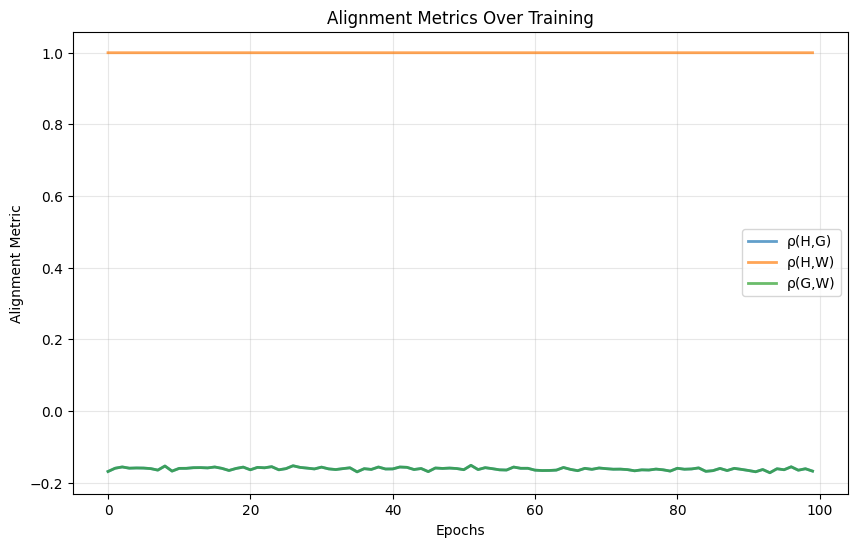

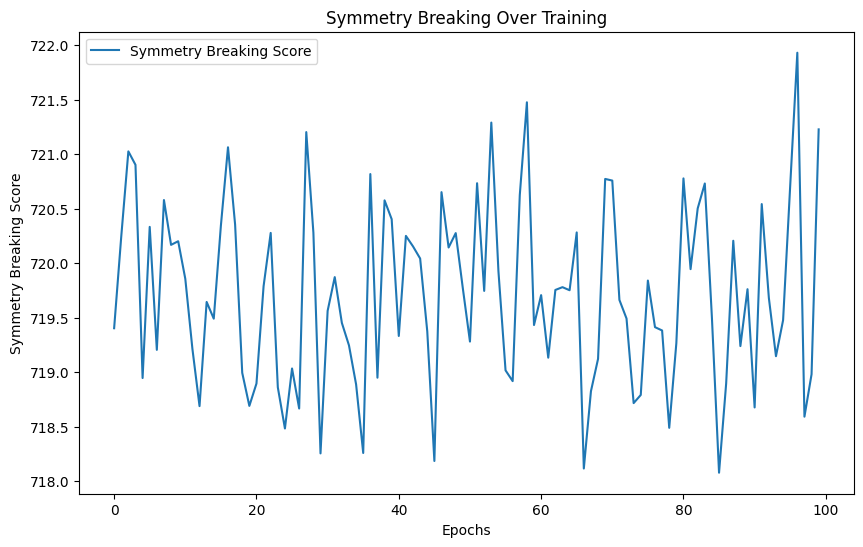

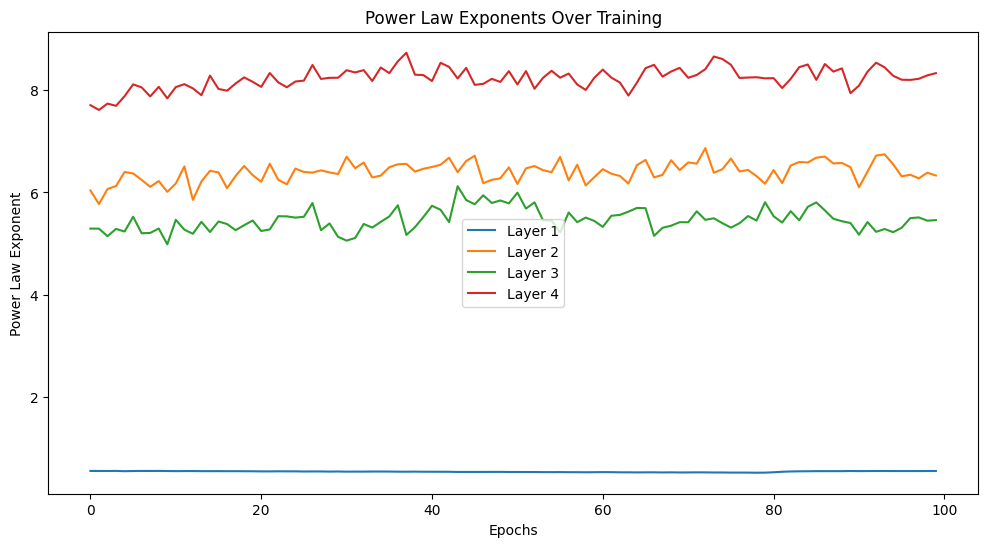

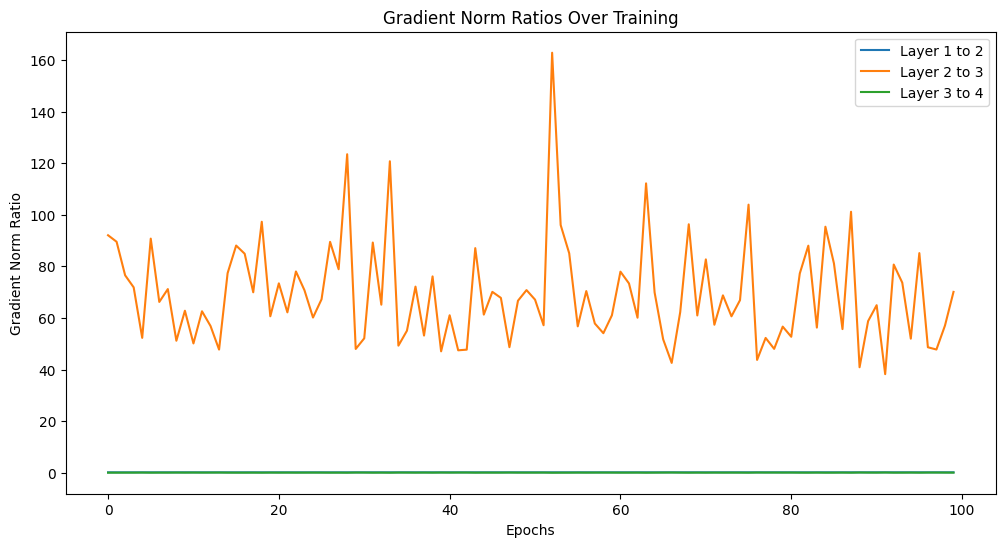

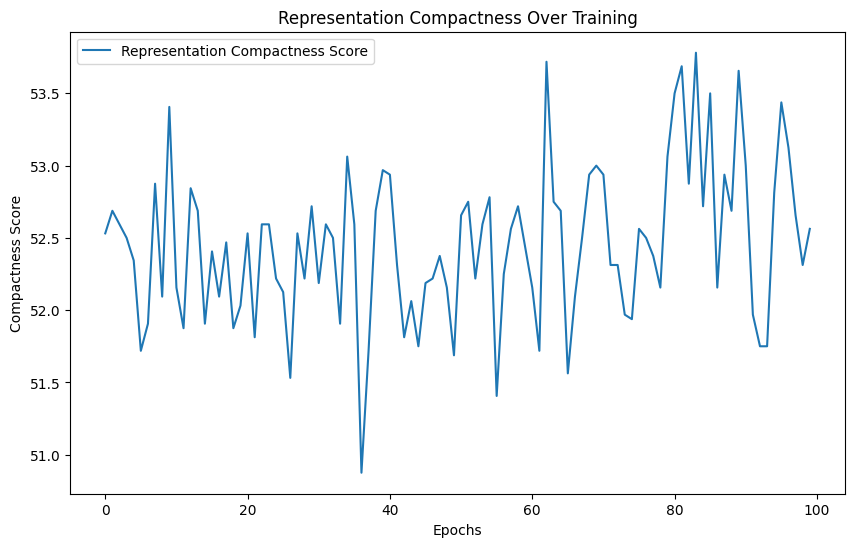

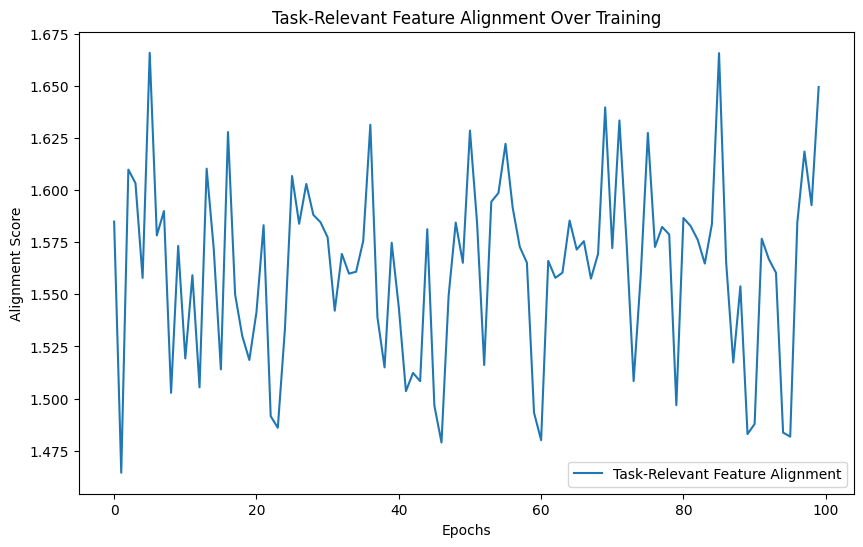

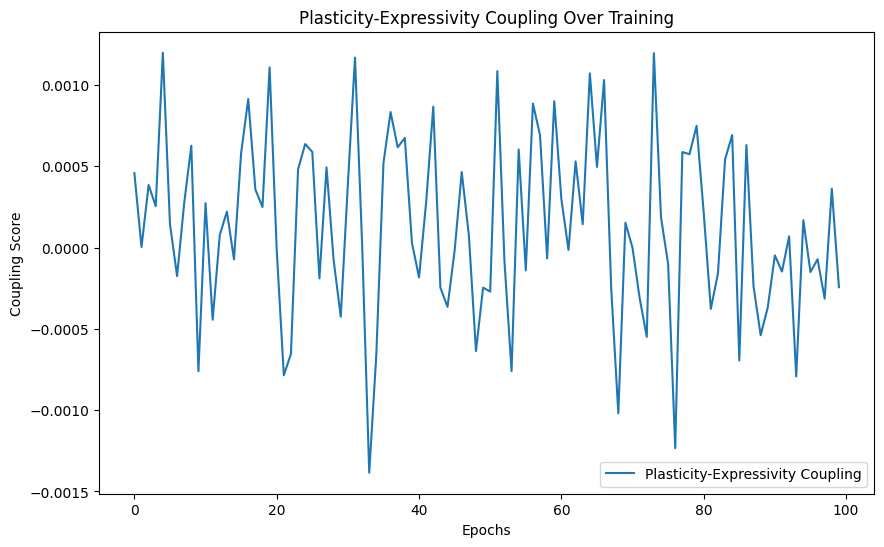

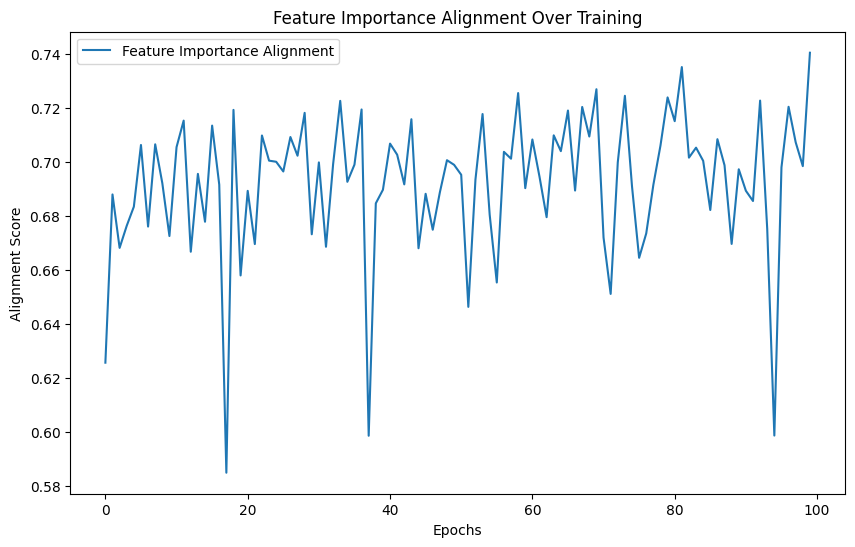

In [31]:
# Train model and collect metrics
alignment_history, symmetry_breaking_history, power_law_history, gnr_history, rcs_history, trfa_history, pec_history, fia_history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=100,
    lr=0.001,
    weight_decay=0.02,
    device=device,
    group_transforms=group_transforms
)

# Plot all metrics
plot_alignment_metrics(alignment_history)
plot_symmetry_breaking(symmetry_breaking_history)
plot_power_laws(power_law_history)
plot_gradient_norm_ratios(gnr_history)
plot_representation_compactness(rcs_history)
plot_task_relevant_feature_alignment(trfa_history)
plot_plasticity_expressivity_coupling(pec_history)
plot_feature_importance_alignment(fia_history)

## Analysis Metrics

- **Relative Changes**:  
  Shows how much each metric has changed relative to its initial value, normalized by the initial value.

- **Momentum Analysis**:  
  Reveals the rate of change for each metric over time.

- **Cross-Metric Correlations**:  
  A correlation matrix showing how different metrics are related to each other.

- **Stability Scores**:  
  Measures the volatility of each metric (lower values indicate more stability).

- **Metric Entropy**:  
  Quantifies the unpredictability of each metric (higher values indicate more randomness).

- **Phase Space Analysis**:  
  A high-dimensional representation of the relationships between metrics.

In [34]:
# 1. Relative Change Analysis (How much each metric changes relative to its initial value)
def relative_change(history):
    if isinstance(history[0], tuple):
        # Handle tuple metrics by processing each component separately
        initial = np.array(history[0])
        return [(np.array(x) - initial) / initial for x in history]
    elif isinstance(history[0], list):
        # Handle list metrics by converting to numpy array
        history = np.array(history)
        initial = history[0]
        return (history - initial) / initial
    else:
        # Handle scalar metrics
        initial = history[0]
        return [(x - initial) / initial for x in history]

# 2. Momentum Analysis (How quickly metrics are changing)
def momentum(history):
    if isinstance(history[0], tuple):
        # Handle tuple metrics by processing each component separately
        return [np.array(history[i]) - np.array(history[i-1]) for i in range(1, len(history))]
    elif isinstance(history[0], list):
        # Handle list metrics by converting to numpy array
        history = np.array(history)
        return history[1:] - history[:-1]
    else:
        # Handle scalar metrics
        return [history[i] - history[i-1] for i in range(1, len(history))]

# # 3. Cross-Metric Correlations (How different metrics relate to each other)
# def cross_metric_correlation(histories):
#     # Flatten all metrics to 1D arrays
#     flattened_histories = []
#     for h in histories:
#         if isinstance(h[0], tuple):
#             # For tuple metrics, concatenate all components
#             flattened = np.concatenate([np.array(x).flatten() for x in h])
#         elif isinstance(h[0], list):
#             # For list metrics, flatten the array
#             flattened = np.array(h).flatten()
#         else:
#             # For scalar metrics, convert to array
#             flattened = np.array(h)
#         flattened_histories.append(flattened)
    
#     # Find minimum length and align all arrays
#     min_length = min(len(h) for h in flattened_histories)
#     aligned_histories = [h[:min_length] for h in flattened_histories]
    
#     # Compute correlation matrix
#     return np.corrcoef(aligned_histories)

# 4. Metric Stability Analysis (How volatile each metric is)
def stability_score(history):
    if isinstance(history[0], tuple):
        # For tuple metrics, calculate stability for each component and average
        diffs = [np.diff([x[i] for x in history]) for i in range(len(history[0]))]
        return np.mean([np.mean(np.abs(d)) for d in diffs])
    else:
        diffs = np.diff(history)
        return np.mean(np.abs(diffs))

# # 5. Phase Space Analysis (Looking at relationships between metrics in 2D/3D space)
# def phase_space_analysis(histories):
#     # Flatten tuple metrics for phase space analysis
#     flattened_histories = []
#     for h in histories:
#         if isinstance(h[0], tuple):
#             # For tuple metrics, concatenate all components
#             flattened_histories.append(np.concatenate([np.array(x) for x in h]))
#         else:
#             flattened_histories.append(np.array(h))
#     min_length = min(len(h) for h in flattened_histories)
#     aligned_histories = [h[:min_length] for h in flattened_histories]
#     return np.array(aligned_histories).T

# # 6. Metric Entropy Analysis (How unpredictable each metric is)
# def metric_entropy(history):
#     if isinstance(history[0], tuple):
#         # For tuple metrics, calculate entropy for each component and average
#         entropies = []
#         for i in range(len(history[0])):
#             component = [x[i] for x in history]
#             hist, _ = np.histogram(component, bins=20)
#             prob = hist / hist.sum()
#             entropies.append(-np.sum(prob * np.log(prob + 1e-10)))
#         return np.mean(entropies)
#     else:
#         hist, _ = np.histogram(history, bins=20)
#         prob = hist / hist.sum()
#         return -np.sum(prob * np.log(prob + 1e-10))

/var/folders/6p/x54f4_t51z75lb262gn_9w940000gn/T/ipykernel_69875/1881061391.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


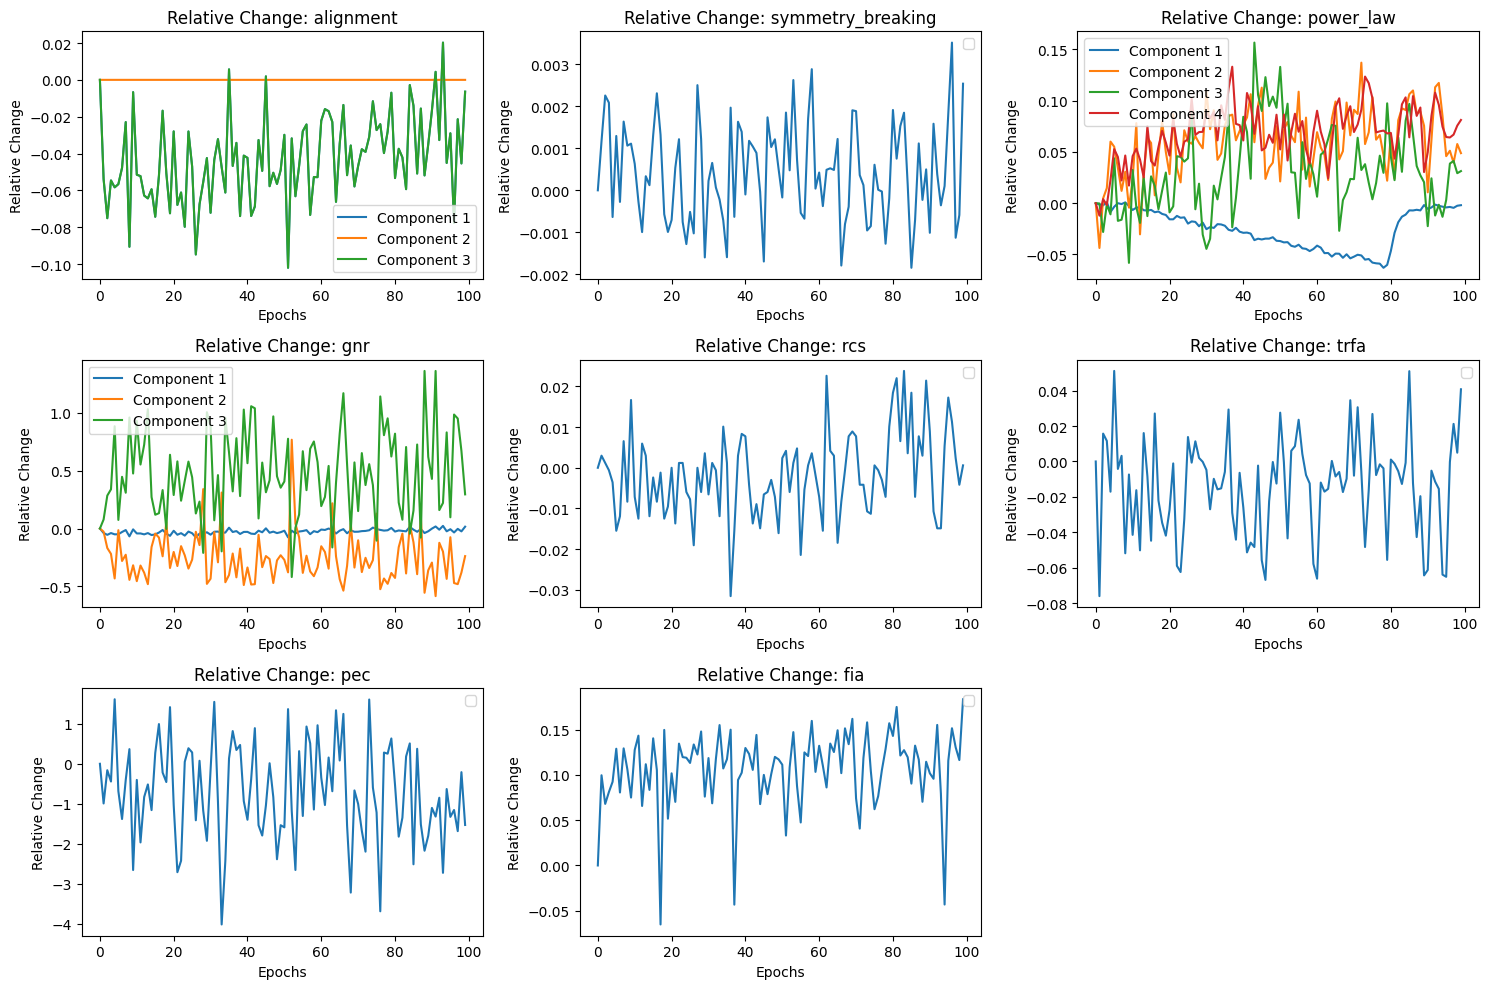

/var/folders/6p/x54f4_t51z75lb262gn_9w940000gn/T/ipykernel_69875/1881061391.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


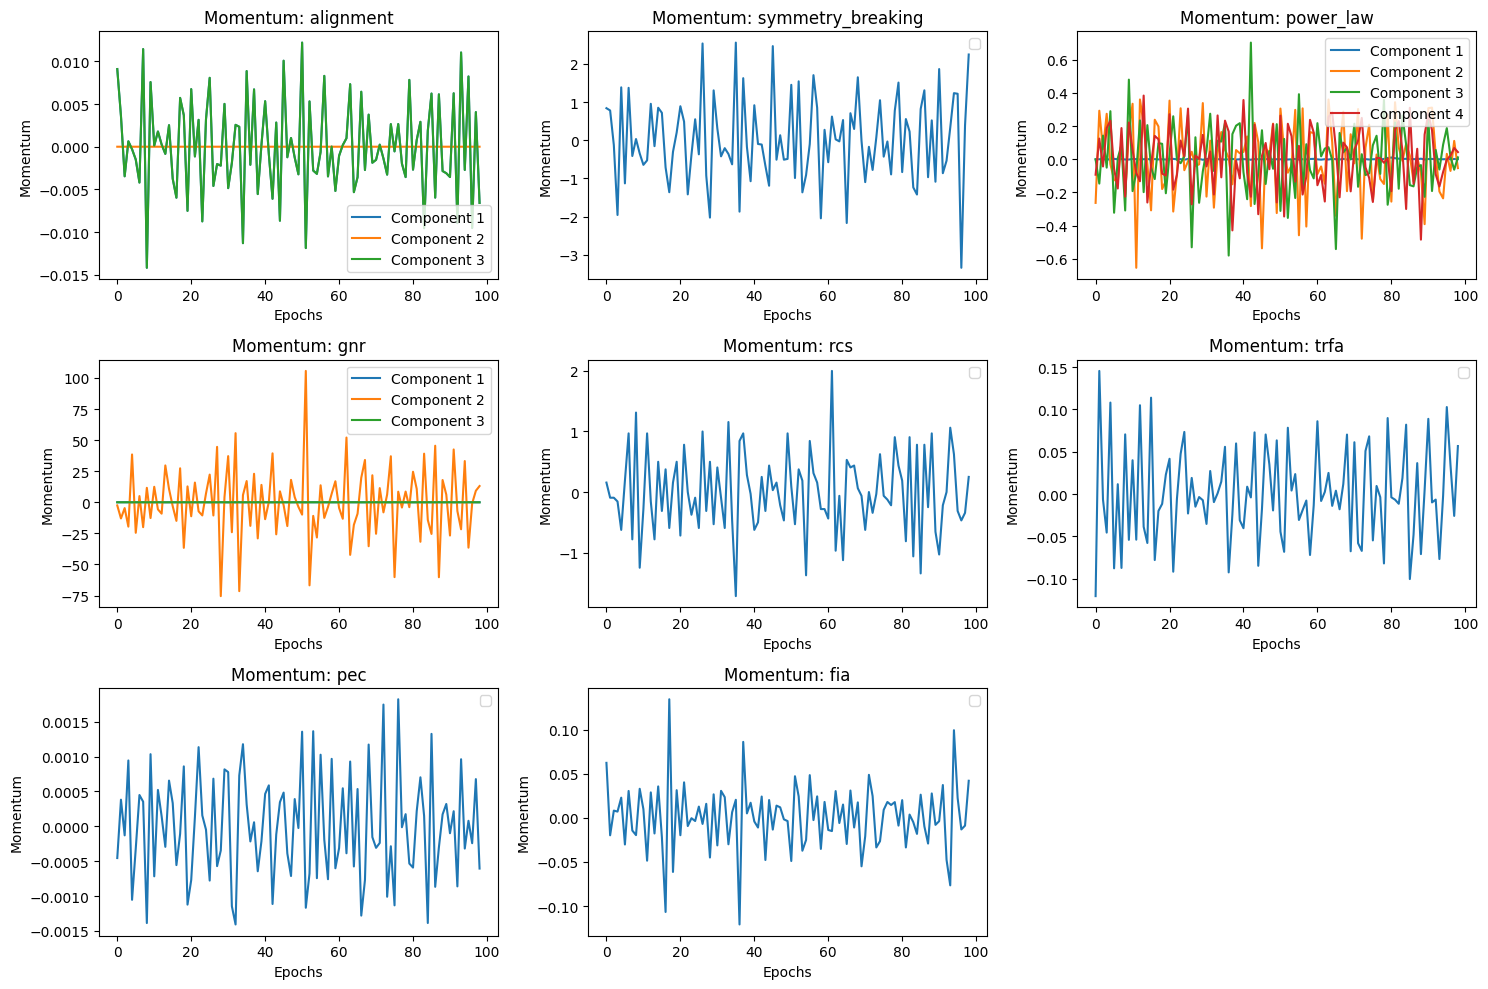


Metric Stability Scores:
alignment: 0.0029
symmetry_breaking: 0.8856
power_law: 3.1900
gnr: 69.1052
rcs: 0.5218
trfa: 0.0442
pec: 0.0006
fia: 0.0277


In [35]:
# Collect all metrics
metrics = {
    'alignment': alignment_history,
    'symmetry_breaking': symmetry_breaking_history,
    'power_law': power_law_history,
    'gnr': gnr_history,
    'rcs': rcs_history,
    'trfa': trfa_history,
    'pec': pec_history,
    'fia': fia_history
}

# 1. Relative Change Analysis
relative_changes = {k: relative_change(v) for k, v in metrics.items()}

# Plot relative changes
plt.figure(figsize=(15, 10))
for i, (metric_name, changes) in enumerate(relative_changes.items(), 1):
    plt.subplot(3, 3, i)
    if isinstance(changes[0], np.ndarray):  # For tuple metrics
        for j in range(len(changes[0])):
            plt.plot([x[j] for x in changes], label=f'Component {j+1}')
    else:
        plt.plot(changes)
    plt.title(f'Relative Change: {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Relative Change')
    plt.legend()
plt.tight_layout()
plt.show()

# 2. Momentum Analysis
momentums = {k: momentum(v) for k, v in metrics.items()}

# Plot momentum
plt.figure(figsize=(15, 10))
for i, (metric_name, mom) in enumerate(momentums.items(), 1):
    plt.subplot(3, 3, i)
    if isinstance(mom[0], np.ndarray):  # For tuple metrics
        for j in range(len(mom[0])):
            plt.plot([x[j] for x in mom], label=f'Component {j+1}')
    else:
        plt.plot(mom)
    plt.title(f'Momentum: {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Momentum')
    plt.legend()
plt.tight_layout()
plt.show()

# # 3. Cross-Metric Correlations
# correlation_matrix = cross_metric_correlation(list(metrics.values()))

# # Plot correlation matrix
# plt.figure(figsize=(10, 8))
# plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
# plt.colorbar()
# plt.xticks(range(len(metrics)), labels=metrics.keys(), rotation=45)
# plt.yticks(range(len(metrics)), labels=metrics.keys())
# plt.title('Cross-Metric Correlations')
# plt.show()

# 4. Metric Stability Analysis
stability_scores = {k: stability_score(v) for k, v in metrics.items()}

# Print stability scores
print("\nMetric Stability Scores:")
for metric, score in stability_scores.items():
    print(f"{metric}: {score:.4f}")

# # 5. Phase Space Analysis
# phase_space_data = phase_space_analysis(list(metrics.values()))

# # Plot 2D phase space (example: alignment vs symmetry_breaking)
# plt.figure(figsize=(10, 6))
# plt.scatter(phase_space_data[:, 0], phase_space_data[:, 1], c=range(len(phase_space_data)), cmap='viridis')
# plt.colorbar(label='Epoch')
# plt.xlabel('Alignment')
# plt.ylabel('Symmetry Breaking')
# plt.title('Phase Space: Alignment vs Symmetry Breaking')
# plt.show()

# # 6. Metric Entropy Analysis
# entropies = {k: metric_entropy(v) for k, v in metrics.items()}

# # Print metric entropies
# print("\nMetric Entropies:")
# for metric, entropy in entropies.items():
#     print(f"{metric}: {entropy:.4f}")